* Name: `dissipation-theory--Study-23.ipynb`
* Author: John A. Marohn
* Date: 2024-08-02
* Continued from: `dissipation-theory--Study-21.ipynb`
* Continued to: ---
* Summary: Plot cantilever friction and BLDS signal versus conductivity and charge density.

# Preliminaries

In [1]:
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [3]:
from dissipationtheory.constants import ureg, qe
from dissipationtheory.dissipation2 import CantileverModelJit, SampleModel1Jit, SampleModel2Jit, theta1norm_jit
from dissipationtheory.dissipation  import blds_perpendicular_jit, gamma_perpendicular_jit
from dissipationtheory.data import BLDSData

In [4]:
THIS = 'dissipation-theory--Study-23--'
fig = {}

# Simulate BLDS and friction under optical irradiation

Assume the density increases while the charge mobility stays constant.

Cantilever with "new" tip might have a radius of $R = 35 \: \mathrm{nm}$.  BLDS measurements might be taken at $d = 200 \: \mathrm{nm}$.  Friction ringdown measurements can get as close as $d = 38 \: \mathrm{nm}$.  

In [5]:
cantilever_jit = CantileverModelJit(
    f_c = 75e3, 
    V_ts = 1.0,
    R = 35e-9,
    d = 38e-9
)

Pick a thick sample, $h_{\mathrm{s}} = 500 \: \mathrm{nm}$.  Guess a dielectric constant on the low side for a perovskite, $\epsilon_{\mathrm{r}} = 20$, to get a larger BLDS signal.  A reasonable guess for a perovskite dielectric constant is 20 to 100 (real part); pick -2 for the imaginary part, an arbitrary choice.  We are going to vary the conductivity and charge density.

Assume the sample is backed by a metal, which we mimic by setting $\epsilon_{\mathrm{d}} = 10^{6}$.

In [6]:
sample_jit = SampleModel1Jit(
    cantilever = cantilever_jit,
    h_s = 500e-9,
    epsilon_s = complex(20, -0.2),
    sigma = 1e-5,
    rho = 1e21,
    epsilon_d = complex(1e6, 0),
    z_r = 300e-9
)

Print out a report of sample properties.

In [7]:
sample_jit.print()

cantilever
   cantilever freq =  75000.0 Hz
                   =  471238.89803846896 rad/s
tip-sample voltage =  1.0 V
            radius =  3.5e-08 m
            height =  3.8e-08 m

semiconductor
          epsilon (real) =  20.0
          epsilon (imag) =  -0.2
               thickness =  5e-07 m
            conductivity =  1e-05 S/m
          charge density =  1e+21 m^{{-3}}
        reference height =  3e-07 m
 
      roll-off frequency =  1129409.0673730192 Hz
                mobility =  6.241509090043337e-08 m^2/(V s)
      diffusion constant =  1.6135549206567651e-09 m^2/s
            Debye length =  3.7797775481848936e-08 m
        diffusion length =  5.851555252782804e-08 m
effective epsilon (real) =  20.0
effective epsilon (imag) =  -2.5966804779363124

dielectric
 epsilon (real) =  1000000.0
 epsilon (imag) =  0.0
      thickness = infinite


Vary the coductivity, but keep the mobility fixed, which means we must also vary charge density.

In [8]:
omega_m = ureg.Quantity(
    np.logspace(
        start=np.log10(1e1),
        stop=np.log10(1e8),
        num=50), 'Hz')

In [9]:
sigma = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-9),
        stop=np.log10(1e-2),
        num=40), 'S/m')

Assume a *fixed* mobility of $\mu = 10^{-8} \: \mathrm{m}^2 / \mathrm{V s}$.  This is an ionic mobility. 

In [10]:
mu = ureg.Quantity(1e-8, 'm^2/(V s)')  # <=== adjust this

print("mu = {:e} cm^2(V s)".format(
    mu.to('cm^2/(V s)').magnitude))

mu = 1.000000e-04 cm^2(V s)


As we vary $\sigma$, we also need to vary $\rho$.

In [11]:
rho = (sigma / (qe * mu)).to('1/m^3')

print("rho range: {:e} to {:e} 1/m^3".format(
    min(rho).to('1/m^3').magnitude,
    max(rho).to('1/m^3').magnitude))

rho range: 6.241509e+17 to 6.241509e+24 1/m^3


Get ready to run the simulations.

In [12]:
data = {}        # many simulations
data['01'] = {}  # the first simulation

Step the charge density and conductivity and compute a friction and BLDS spectrum at each step.

In [13]:
# remember
sigma0 = sample_jit.sigma
rho0 =  sample_jit.rho

# set
for rho_, sigma_ in zip(rho, sigma):
    
    freq = ureg.Quantity(np.zeros_like(omega_m), 'Hz')

    sample_jit.rho = rho_.to('1/m^3').magnitude
    sample_jit.sigma = sigma_.to('S/m').magnitude
    
    gamma = gamma_perpendicular_jit(theta1norm_jit, sample_jit).to('pN s/m')
    
    for index, omega_ in enumerate(omega_m):
        
        freq[index] = blds_perpendicular_jit(
            theta1norm_jit,
            sample_jit,
            omega_).to('Hz')
    
    data['01'][str(sigma_)] = {
        'omega_m': omega_m,
        'f_BLDS': freq, 
        'gamma': gamma,
        'sigma': ureg.Quantity(sample_jit.sigma, 'S/m'), 
        'rho': ureg.Quantity(sample_jit.rho, '1/m^3')}

# reset
sample_jit.rho = rho0
sample_jit.sigma = sigma0

Helper function to plot the BLDS spectra.

In [45]:
def plotBLDS(data, sample_jit):

    rho = np.zeros(len(data))    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude

    # colormap = plt.cm.jet
    colormap = plt.cm.magma_r
    color_list = [colormap(i) for i in np.linspace(0, 1, len(data))]

    normalized_colors = mcolors.LogNorm(vmin=min(rho), vmax=max(rho))
    scalar_mappable = cm.ScalarMappable(norm=normalized_colors, cmap=colormap)
    scalar_mappable.set_array(len(color_list))
    
    fig, ax = plt.subplots(figsize=(4.5, 3))
    for index, key in enumerate(data.keys()):
        
        with plt.style.context('seaborn-v0_8'):
            plt.semilogx(
                data[key]['omega_m'].to('Hz').magnitude,
                np.abs(data[key]['f_BLDS'].to('Hz').magnitude),
                '-',
                color=color_list[index])

    # if you want the separation and radius on the plot title
    if 0: 
    
        lbl = '$d = $ {:0.1f} nm, $R = $ {:0.1f} nm'.format(
            sample_jit.cantilever.d/1e-9,
            sample_jit.cantilever.R/1e-9)
        
        plt.title(lbl, fontsize=9)

    # color bar
    clb=plt.colorbar(scalar_mappable, ax=ax)
    clb.ax.set_title(r'$\rho \: [\mathrm{cm}^{-3}]$', fontsize=12)
    
    plt.ylabel('|$\Delta f_{\mathrm{BLDS}}$| [Hz]')
    plt.xlabel('mod. freq. $\omega_{\mathrm{m}}$ [rad/s]')
    plt.tight_layout()
    plt.show()
    
    return fig

Plot the BLDS spectra.

Actually plot a subset of the BLDS spectra.

In [46]:
data['01-short'] = {}
for key in list(data['01'].keys())[::2]:  # gotta list, MF'a
    data['01-short'][key] = data['01'][key]

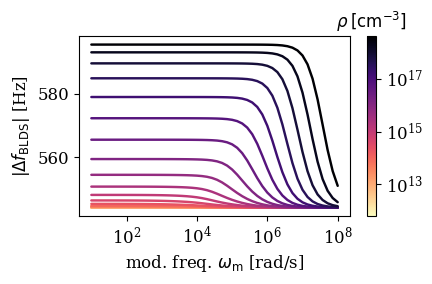

In [47]:
fig['01'] = plotBLDS(data['01-short'], sample_jit)

Helper function to plot the dissipation.

In [18]:
def plotgamma(data, sample_jit):

    # gather up friction data
    
    rho = np.zeros(len(data))
    gamma = np.zeros(len(data))
    blds0 = np.zeros(len(data))
    
    for index, key in enumerate(data.keys()):
        
        rho[index] = data[key]['rho'].to('1/cm^3').magnitude
        gamma[index] = data[key]['gamma'][0].to('pN s/m').magnitude
        blds0[index] = np.abs(data[key]['f_BLDS'][0].to('Hz').magnitude)
        
    # now make a plot
    
    fig, ax = plt.subplots(1, 2, figsize=(6.5, 3))

    with plt.style.context('seaborn-v0_8'):
        ax[0].semilogx(rho, blds0, '-')
        ax[1].semilogx(rho, gamma, '-')
        
    ax[0].set_ylabel(r'|$\Delta f_{\mathrm{BLDS}}(\omega_{\mathrm{m}}=0)$| [Hz]')
    ax[1].set_ylabel(r'$\gamma_{\perp}$ [pN s/m]')
    ax[0].set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    ax[1].set_xlabel(r'charge density $\rho$ [cm$^{-3}$]')
    
    plt.tight_layout()
    plt.show()
    
    return fig

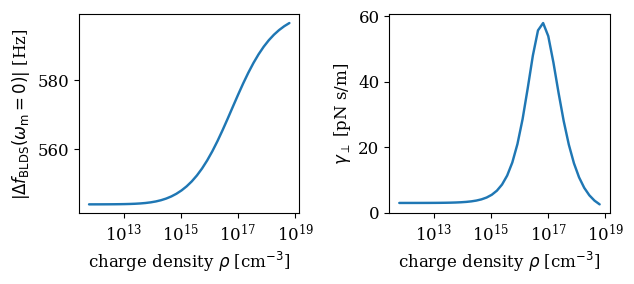

In [19]:
fig['02'] = plotgamma(data['01'], sample_jit)

Print out the sample properties again.

Cantilever: $f_c = 75 \: \mathrm{kHz}$, $k_c = 2.8 \: \mathrm{N/m}$, $R = 35 \: \mathrm{nm}$, $h = 38 \: \mathrm{nm}$, and $V_{\mathrm{ts}} = 1 \: \mathrm{V}$.

Sample: $h_{\mathrm{s}} = 500 \: \mathrm{nm}$, $\epsilon_{\mathrm{s}} = 20 - 0.2 \, j$, $\mu = 10^{-8} \: \mathrm{m}^2 / \mathrm{V s}$, $\epsilon_{\mathrm{d}} = 10^{6}$ fixed; $\rho$ and $\sigma = e \mu \rho$ varied.

In [20]:
sample_jit.print()

cantilever
   cantilever freq =  75000.0 Hz
                   =  471238.89803846896 rad/s
tip-sample voltage =  1.0 V
            radius =  3.5e-08 m
            height =  3.8e-08 m

semiconductor
          epsilon (real) =  20.0
          epsilon (imag) =  -0.2
               thickness =  5e-07 m
            conductivity =  1e-05 S/m
          charge density =  1e+21 m^{{-3}}
        reference height =  3e-07 m
 
      roll-off frequency =  1129409.0673730192 Hz
                mobility =  6.241509090043337e-08 m^2/(V s)
      diffusion constant =  1.6135549206567651e-09 m^2/s
            Debye length =  3.7797775481848936e-08 m
        diffusion length =  5.851555252782804e-08 m
effective epsilon (real) =  20.0
effective epsilon (imag) =  -2.5966804779363124

dielectric
 epsilon (real) =  1000000.0
 epsilon (imag) =  0.0
      thickness = infinite


# Save all figures

In [48]:
for num in fig.keys():
    figname = THIS + "Fig-" + num
    fig[num].savefig(figname + '.png', dpi=300)
    fig[num].savefig(figname + '.pdf')